# Quick start guide for running MIHT

## 1. Prepare the Python environment of execution

The [requirements.yml](requirements.yml) file lists all the necessay dependencies. With [Conda](https://docs.conda.io/projects/conda/en/stable/user-guide/getting-started.html), it can be used to create the environment automatically.

In [ ]:
conda env create --file src/requirements.yml
conda activate miht

## 2. Prepare the data

MIHT works with the popular formats of [pandas.MultiIndex](https://pandas.pydata.org/docs/reference/api/pandas.MultiIndex.html) for the input time series, and [numpy.ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) for the targets of the classification. This favors the integration with popular libraries in Python for time-series classification like [Sktime](https://www.sktime.net/en/stable/). In fact, the most direct way to work with public datasets is to load them using that library:

In [2]:
from sktime.datasets import load_UCR_UEA_dataset

dataset = 'GunPoint' # String with the name of the dataset as it appears in http://www.timeseriesclassification.com/dataset.php
X_train, y_train = load_UCR_UEA_dataset(name=dataset, return_type="pd-multiindex", split="train") # train partition
X_test, y_test = load_UCR_UEA_dataset(name=dataset, return_type="pd-multiindex", split="test") # test partition

The inputs are 3-dimensional data frames where:
* The 1st index identifys each time series composing the dataset.
* The 2nd index `timepoints` is for counting the steps in each time series.
* The 3rd set of indexes are the variables of the multi-variate time series.

In [2]:
X_train

dim_0
   timepoints          
0  0          -0.647885
   1          -0.641992
   2          -0.638186
   3          -0.638259
   4          -0.638345
...                 ...
49 145        -1.436885
   146        -1.434493
   147        -1.435462
   148        -1.435282
   149        -1.430884

[7500 rows x 1 columns]

In [3]:
X_train.describe()

,dim_0
count,7.500000e+03
mean,-1.981200e-10
std,9.967275e-01
min,-2.369231e+00
25%,-7.699255e-01
50%,-5.460726e-01
75%,9.627856e-01
max,2.053367e+00


On the other hand, the targets of the classification will be just an array with so many elements as time series in the dataset.

In [4]:
print(y_train)

['2' '2' '1' '1' '2' '2' '2' '2' '2' '1' '1' '1' '1' '1' '2' '1' '2' '2'
 '1' '2' '1' '1' '1' '2' '1' '2' '1' '1' '2' '1' '1' '2' '2' '1' '2' '1'
 '2' '2' '2' '2' '2' '1' '1' '1' '2' '2' '1' '2' '1' '2']


In order to work with them in our Multi-Instance Learning framework, we need to transform them to numerical categories.

In [3]:
from utils import ordinal_targets
y_train = ordinal_targets(dataset, y_train)
y_test = ordinal_targets(dataset, y_test)
print(y_train)

[1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1]


## 3. Create and train the MIHT model

MIHT, from Multi-Instance Hoeffding Tree, is configured with the parameters:
* `grace_period`: Number of instances a leaf in the decision tree should observe between split attempts.
* `delta`: Significance level to calculate the Hoeffding bound. The significance level is given by 1 - delta. Values closer to zero imply longer split decision delays in the decision tree.
* `mil_assumption`: Multi-instance learning assumption to model the relationship between instances in a bag.
    - 'max' - The bag label is the maximum of the instances labels.
    - 'mean' - The bag label is the mean average of the instances labels.
    - 'mode' - The bag label is the most repeated instance label.
* `inst_len`: Length with which to construct the instances that will compose the bag oa time series. If it is a integer, it will be interpreted as time steps. If it is a float in [0, 1] it will be interpreted as a percentage of the total time series.
* `inst_stride`: Displacement between the start of a instance and the next one (the opposite to the overlap between instances). If it is a integer, it will be interpreted as time steps. If it a float in [0, 1] it will be interpreted as a percentage of the instance length.
* `k`: Number of consecutive instances in a bag that should contain the concept of the series.
* `max_it`: Hard limit in the number of iterations to stop the optimization process of the k best instances of the bag.
* `max_patience`: Early stopping mechanism to stop the optimization process if the accuracy does not improve for this number of iterations.

MIHT source code is available in the file [miht.py](miht.py), under the class name MultiInstanceHoeffdingTreeClassifier. To define and train it, we do as follow:

In [4]:
from miht import MultiInstanceHoeffdingTreeClassifier

model = MultiInstanceHoeffdingTreeClassifier(grace_period=500, delta=8.02e-4, mil_assumption='mode', inst_len=0.6, inst_stride=0.4, k=2)
acc_hist, selection = model.fit(X_train, y_train)

The fitting function will return the history of the accucary during the iterative training process, as well as the index of the best k instances in each bag for the training set.

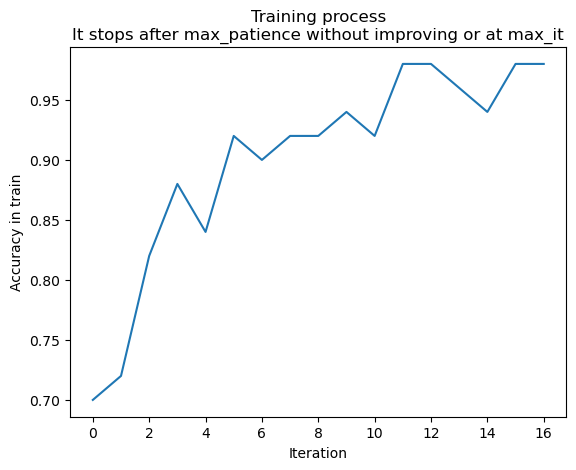

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(acc_hist)
ax.set_ylabel('Accuracy in train')
ax.set_xlabel('Iteration')
ax.set_title('Training process\nIt stops after max_patience without improving or at max_it')
plt.show()

## 4. Generate predictions

To generate predictions once the model has been fitted, we call the method predict with the test set, that will return the predicted targets.

In [15]:
y_test_pred = model.predict(X_test)

With the output together with the true targets any performance report can be obtained, for example using the Sklearn library.

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.70      0.83      0.76        76
           1       0.78      0.64      0.70        74

    accuracy                           0.73       150
   macro avg       0.74      0.73      0.73       150
weighted avg       0.74      0.73      0.73       150



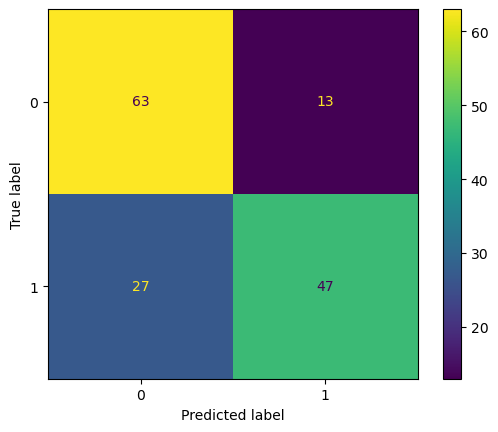

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

Finally, you can also explore visually the developed tree:

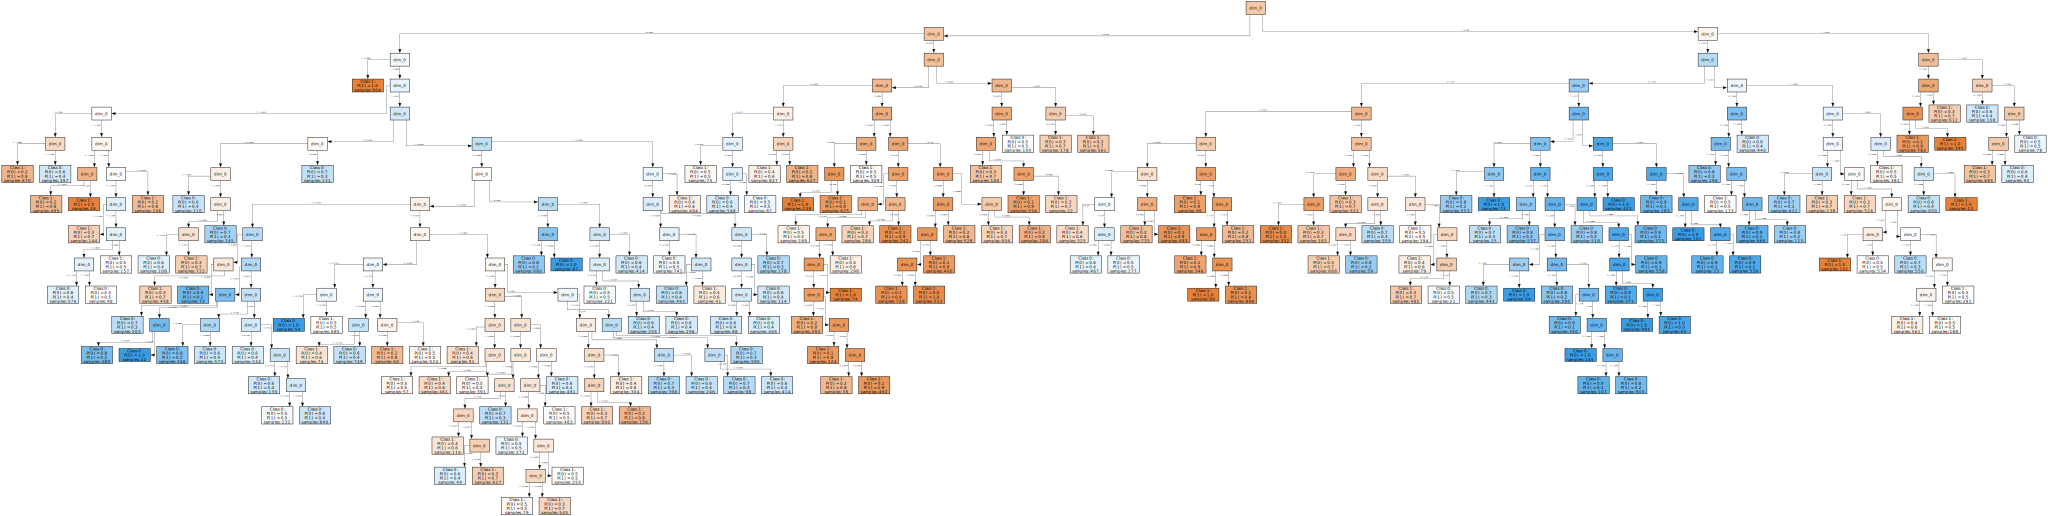

In [5]:
model.online_learner.draw()